In [1]:
import numpy as np 
import os
import torch
from utils.datasetloader import MyDatasetLDCT 
from torch.utils.data import  DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LDCTDatasetLoader:
    def __init__(self, batch_size ):
        #dataset_path = "dataset/"
        dataset_path = "dataset/LDCT_npy"

        # Eğitim ve doğrulama verilerini yükle 
        x_val = np.load(os.path.join(dataset_path, 'x_val.npy'))
        y_val = np.load(os.path.join(dataset_path, 'y_val.npy'))

 
        val_set = MyDatasetLDCT(x=x_val, y=y_val, max_val=0, min_val=0, aug=False)
        dataloader= DataLoader(val_set, batch_size=batch_size, shuffle=True, pin_memory=True )
     
        self.dataloader = dataloader


  
def output_scaling( sigma,sigma_data=0.5,sigma_min=0.002,
        )  :

            return  sigma_data * (sigma -  sigma_min) / ( sigma_data**2 + sigma**2) ** 0.5
     
  
def in_scaling(sigma ,sigma_data=0.5
        )  :

            return 1/(((sigma**2 + sigma_data**2))**0.5)

def skip_scaling(sigma ,sigma_data=0.5,sigma_min=0.002,
        ) :
            
            return  sigma_data**2 / ((sigma -  sigma_min) ** 2 +  sigma_data**2)
    
  
def pad_dims_like(x, other) :

        ndim = other.ndim - x.ndim
        return x.view(*x.shape, *((1,) * ndim))
    

def model_forward_wrapper( model ,x ,sigma, cond)  :
        

            c_skip =  skip_scaling(sigma )
            c_out =  output_scaling(sigma) 
            c_in =  in_scaling(sigma)  
              
            
            c_skip =  pad_dims_like(c_skip, x).to(device)
            c_out =  pad_dims_like(c_out, x).to(device)
            c_in = pad_dims_like(c_in,x).to(device)  
            
            return c_skip   * x + c_out  * model( x* c_in, 0.25 * torch.log(sigma).to(device) , cond)

def sample( model,f_img,q_img  ): 
             
            first_sigma = 80
            
            y= torch.randn_like(q_img) * first_sigma
            
            sigma = torch.full((y.shape[0],), first_sigma, dtype=y.dtype ) 

            y=  model_forward_wrapper(model,y,sigma, cond=q_img) 
            y= y.clamp(-1.0, 1.0) 
            return y 

  
test_dataloader= LDCTDatasetLoader(batch_size=4).dataloader

tensor(0.5378, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.6373, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5273, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.6239, device='cuda:0')
tensor(0., device='cuda:0')


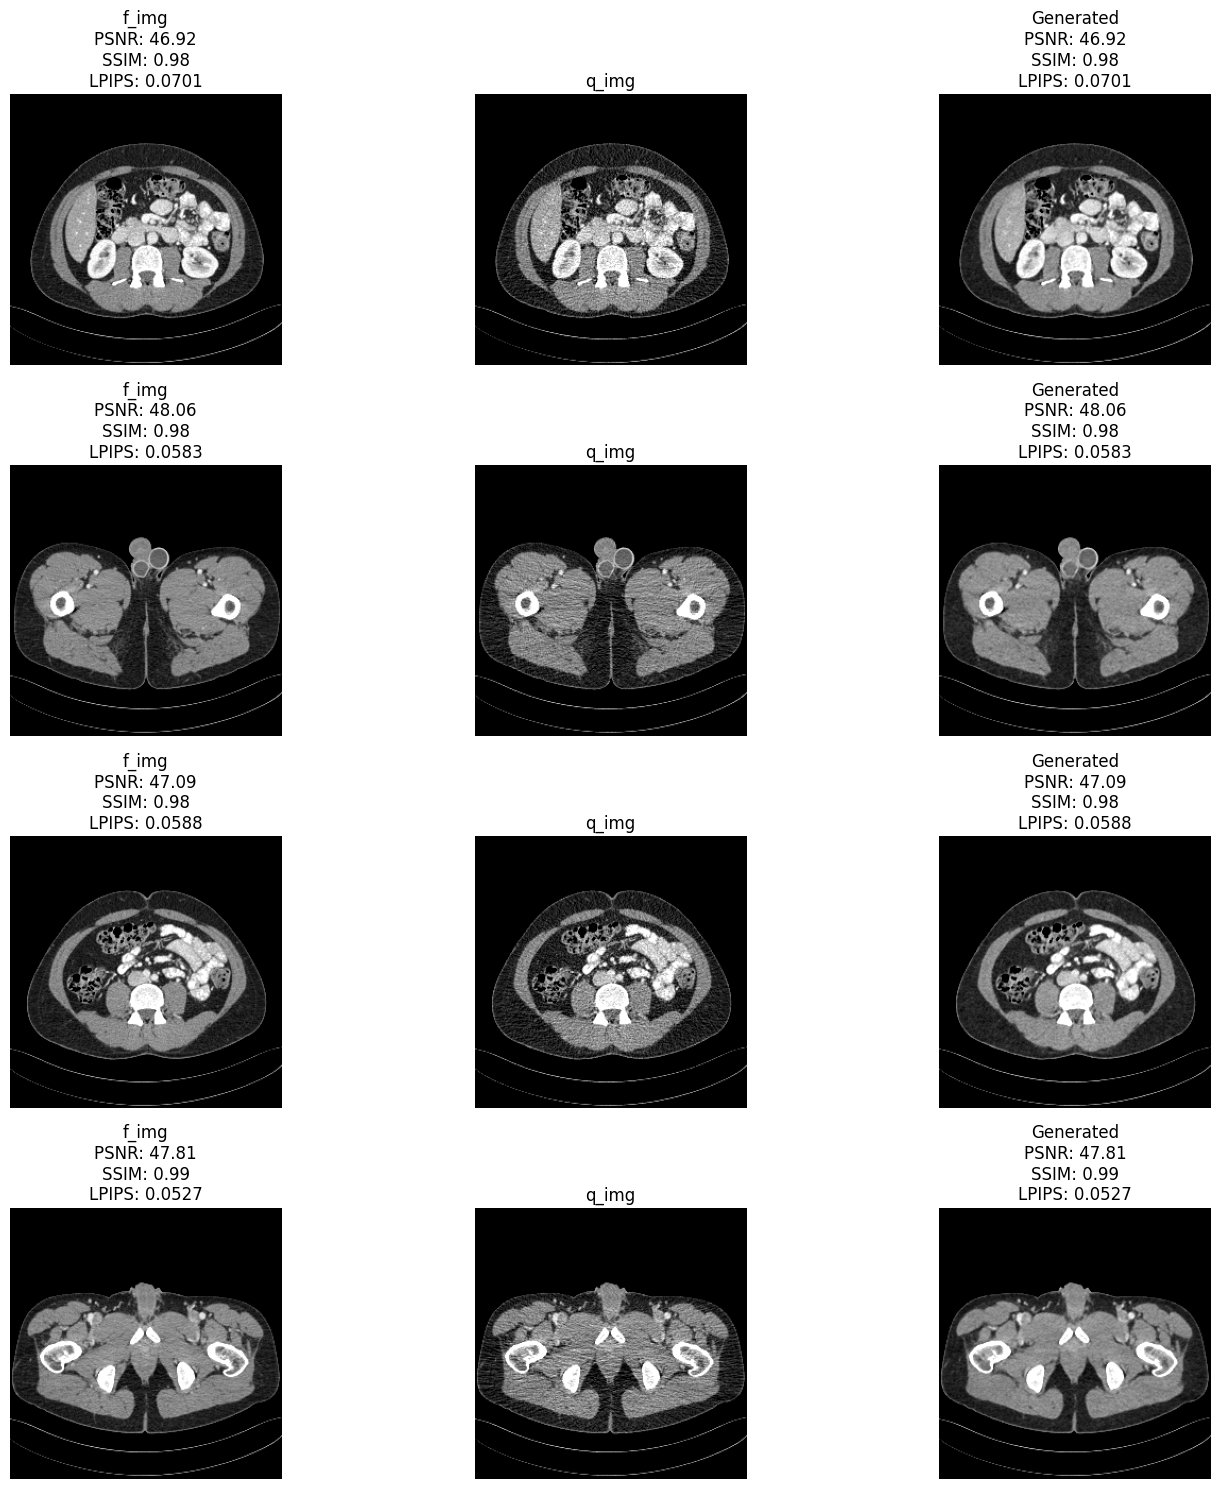

In [21]:
import matplotlib.pyplot as plt
import torch

from architectures.UNET_CT.unet_ct import UNET_CT
from utils.common_functions import get_checkpoint  
from torchmetrics.functional.image.psnr import peak_signal_noise_ratio
from torchmetrics.functional.image.ssim import structural_similarity_index_measure
from torchmetrics.functional.image.lpips import learned_perceptual_image_patch_similarity

norm_range_max = 3072.0
norm_range_min = -1024.0 
trunc_min = -160.0
trunc_max = 240.0

model = UNET_CT(device='cuda:0', img_channels=1, groupnorm=32, dropout=0, base_channels=128, num_head_channels=64, num_res_blocks=4).to(device=0)

def trunc(mat):
    mat = mat.clip(trunc_min, trunc_max) 
    return mat

def denormalize_(image):
    image = image * (norm_range_max - norm_range_min) + norm_range_min
    return image

batch_size = 16
state_dict = get_checkpoint(epoch=400000, model_name='hn_ldct_medium')
model.load_state_dict(state_dict) 
model.eval()

# Assuming test_dataloader is defined
for q_img, f_img in test_dataloader: 
    f_img = f_img.to(device)
    q_img = q_img.to(device)
    with torch.no_grad():
        generated_images = sample(f_img=f_img, q_img=q_img, model=model)
    
    # Normalize for LPIPS calculation
    f_img = (f_img * 0.5 + 0.5).clamp(0, 1)
    f_img_lpips =f_img
    f_img_lpips=f_img_lpips.repeat(1,3,1,1)
    q_img = (q_img * 0.5 + 0.5).clamp(0, 1)
    q_img_lpips = q_img
    q_img_lpips=q_img_lpips.repeat(1,3,1,1)
    generated_images = (generated_images * 0.5 + 0.5).clamp(0, 1)
    generated_images_lpips =generated_images
    generated_images_lpips=generated_images_lpips.repeat(1,3,1,1)
    
    # Denormalize for other metrics
    f_img = denormalize_(f_img)
    q_img = denormalize_(q_img)
    generated_images = denormalize_(generated_images)
 
    f_img_np = f_img.cpu().numpy()
    q_img_np = q_img.cpu().numpy()
    generated_images_np = generated_images.cpu().numpy()
    
    fig, axes = plt.subplots(4, 3, figsize=(15, 15)) 
    
    for i in range(4): 
        psnr_value = peak_signal_noise_ratio(target=f_img[i:i+1], preds=generated_images[i:i+1], data_range=(norm_range_min, norm_range_max )).item()
        ssim_value = structural_similarity_index_measure(target=f_img[i:i+1], preds=generated_images[i:i+1], data_range=(norm_range_min,norm_range_max)).item()
          
        lpips_value= learned_perceptual_image_patch_similarity(generated_images_lpips[i:i+1] , f_img_lpips[i:i+1] , net_type='vgg',normalize=True ).item()
        # Plot images
        axes[i, 0].imshow(trunc(f_img_np[i, 0]), cmap='gray')
        axes[i, 0].set_title(f'f_img\nPSNR: {psnr_value:.2f}\nSSIM: {ssim_value:.2f}\nLPIPS: {lpips_value:.4f}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(trunc(q_img_np[i, 0]), cmap='gray')
        axes[i, 1].set_title('q_img')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(trunc(generated_images_np[i, 0]), cmap='gray')
        axes[i, 2].set_title(f'Generated\nPSNR: {psnr_value:.2f}\nSSIM: {ssim_value:.2f}\nLPIPS: {lpips_value:.4f}')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    break